In [2]:
from collections import Counter
import numpy as np
import tskit


In [25]:
# Generate these trees by running pytest tests/test_inference.py
ts_file = "../tests/data/cache/2020-02-13.ts"
ts = tskit.load(ts_file)
ts


In [26]:
mut_labels = {}
mut_pos = []
mut_types = []

for mut in ts.mutations():
    site = ts.site(mut.site)
    pos = int(site.position)
    older_mut = mut.parent >= 0
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = f"{prev}{pos}{mut.derived_state}"
    mut_pos.append(pos)
    mut_types.append(f"{prev}{mut.derived_state}")

# What is A1547-? One-base deletion in ORF1a.
Counter(mut_types)


Counter({'CT': 38,
         'GT': 8,
         'AG': 7,
         'TC': 7,
         'GA': 4,
         'A-': 1,
         'TA': 1,
         'GC': 1,
         'CA': 1})

In [27]:
# There is one site having two mutations.
mut_pos_counts = Counter(mut_pos)
for k, v in mut_pos_counts.items():
    if v > 1:
        print(f"pos: {k}; count: {v}")


pos: 29742; count: 2


In [28]:
# There should be no recurrent mutations this early.
all(np.array(list(Counter(mut_labels.values()).values()), dtype=int) == 1)


True

In [29]:
# The majority of samples should be from the lineage B, with some from the lineage A.
node_labels = {}
pango_labels = []
for node in ts.nodes():
    if node.is_sample() and "Viridian_pangolin" in node.metadata:
        strain = node.metadata["strain"]
        pango = node.metadata["Viridian_pangolin"]
        node_labels[node.id] = f"{node.id} {pango}\n{strain}"
        pango_labels.append(pango)
    else:
        node_labels[node.id] = f"{node.id}"
Counter(pango_labels)


Counter({'B': 24, 'A': 15, 'B.1': 4, 'B.40': 3, 'B.4': 1, 'B.33': 1})

In [30]:
# Check polytomy at the top.
ts.first().num_children_array


array([ 1, 16,  0,  0,  0,  5,  0,  0,  1, 13,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  4,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,
        2,  0,  0,  0,  0,  3,  0,  0,  0,  0,  2,  2,  0,  0,  0,  0,  2,
        0,  2,  0,  2,  0,  0,  0,  0,  0,  0,  2,  1], dtype=int32)

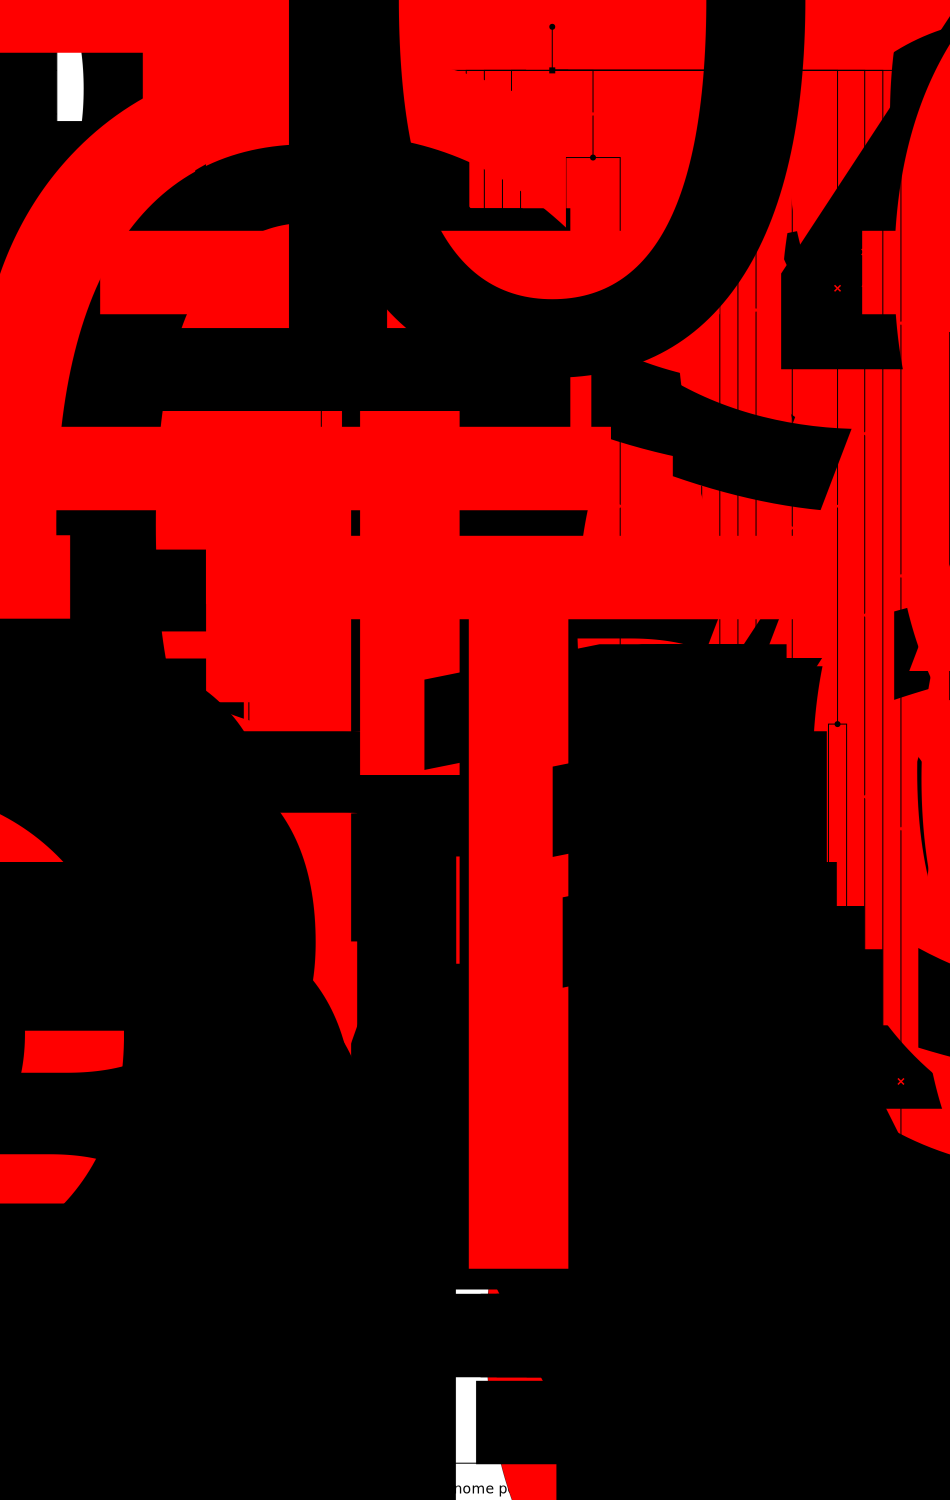

In [31]:
# Note that lineages A and B are characterised by differences at two site positions: 8782 and 28144.
# Lineage B samples have 8782C and 28144T, whereas lineage A samples have 8782T and 28144C.
# 
# The reference Wuhan-Hu-1 belongs to lineage B, and is arbitrarily chosen as the root here.
# So, we should expect to see samples from lineage A grouped by two mutations: C8782T and T28144C.
label_style = (
    ".mut > .lab {font-size: 80%; transform: rotate(-25deg) translate(0px)}"
    ".node > .lab {font-size: 80%}"
    ".leaf > .lab {text-anchor: middle; transform: rotate(-35deg) translateY(10px)}"
)

ts.draw_svg(
    node_labels=node_labels,
    mutation_labels=mut_labels,
    y_axis=True,
    time_scale="rank",
    x_scale="treewise",
    size=(950, 1500),
    style=label_style,
)


## Constructing a recombinant

Pick two samples with mutations on opposite sides of the sequence, and create a franken-haplotype

In [55]:
for u in [51, 36]:
    print(ts.node(u).metadata["strain"])

SRR11597163
SRR11597188


In [48]:
def mutations_on_path(u, v):
    tree = ts.first()
    mutations = []
    while u != v:
        for mut_id in np.where(ts.mutations_node == u)[0]:
            mut = ts.mutation(mut_id)
            #pos = int(ts.sites_position[mut.site])
            mutations.append((mut.site, mut.derived_state))
        u = tree.parent(u)
    return sorted(mutations)
    

[(15107, 'T'), (28930, 'T')]

In [58]:
strains = ["SRR11597188", "SRR11597163"]
for strain in strains:
    u = ts.samples()[ts.metadata["sc2ts"]["samples_strain"].index(strain)]
    print(strain, u, mutations_on_path(u, 1), sep="\t")

SRR11597188	36	[(801, 'G'), (2943, 'G'), (3694, 'T')]
SRR11597163	51	[(15107, 'T'), (28930, 'T')]
